<a href="https://colab.research.google.com/github/doaa23-1/Computer-Vision-Project/blob/main/CV_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision Project**

Doaa Brnawi | 2110230

Lamis Melebari | 2110623

Lina Alghamdi | 2110106

### Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skimage.filters import median, gaussian
from skimage.restoration import denoise_bilateral
from skimage import exposure
from skimage.transform import resize
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2

In [ ]:
# Import necessary modules
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import BatchNormalization

### Upload Data from Kaggle

In [ ]:
# Install and set up Kaggle API (remove if not needed)
!pip install kaggle
!mkdir ~/.kaggle
!echo '{"username":"ddooaa","key":"a04fe1ff8e2769f3dfafe07bfc85c811"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d dog-vs-cat
!unzip dog-vs-cat.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/training_set/dogs/motion_blur/dog.37.jpg  
  inflating: dataset/training_set/dogs/motion_blur/dog.370.jpg  
  inflating: dataset/training_set/dogs/motion_blur/dog.3700.jpg  
  inflating: dataset/training_set/dogs/motion_blur/dog.3701.jpg  
  inflating: dataset/training_set/dogs/motion_blur/dog.3702.jpg  
  inflating: dataset/training_set/dogs/motion_blur/dog.3703.jpg  
  inflating: dataset/training_set/dogs/motion_blur/dog.3704.jpg  
  inflating: dataset/training_set/dogs/motion_blur/dog.3705.jpg  
  inflating: dataset/training_set/dogs/motion_blur/dog.3706.jpg  
  inflating: dataset/training_set/dogs/motion_blur/dog.3707.jpg  
  inflating: dataset/training_set/dogs/motion_blur/dog.3708.jpg  
  inflating: dataset/training_set/dogs/motion_blur/dog.3709.jpg  
  inflating: dataset/training_set/dogs/motion_blur/dog.371.jpg  
  inflating: dataset/training_set/dogs/motion_blur/dog.3710.jpg  
  inflating: dataset/training

#### Defining Paths

In [ ]:
# Paths
train_dir = "/content/dataset/training_set"
test_dir = "/content/dataset/test_set"

# Image parameters
img_size = 128
batch_size = 32

### Preprocessing Functions


**custom**

In [ ]:
import numpy as np

def custom_median_filter(img, kernel_size=7):

    # Get the dimensions of the image
    height, width, channels = img.shape
    pad_width = kernel_size // 2  # Padding size for the filter
    # Pad the image with zeros to handle border pixels
    padded_image = np.pad(img, ((pad_width, pad_width), (pad_width, pad_width), (0, 0)), mode='constant', constant_values=0)
    filtered_image = np.zeros_like(img)

    # Apply the median filter
    for i in range(height):  # Loop over rows
        for j in range(width):  # Loop over columns
            for k in range(channels):  # Loop over color channels
                # Extract the region of interest (ROI)
                roi = padded_image[i:i + kernel_size, j:j + kernel_size, k]
                # Compute the median value of the ROI
                filtered_image[i, j, k] = np.median(roi)

    # Apply sharpening
    sharpened_image = custom_sharpen(filtered_image)

    # Apply Gaussian filtering
    final_image = custom_gaussian_filter(sharpened_image)

    return final_image

def custom_sharpen(image):

    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    kernel_size = kernel.shape[0]
    pad_width = kernel_size // 2
    height, width, channels = image.shape
    padded_image = np.pad(image, ((pad_width, pad_width), (pad_width, pad_width), (0, 0)), mode='constant', constant_values=0)
    sharpened_image = np.zeros_like(image)

    for i in range(height):
        for j in range(width):
            for k in range(channels):
                roi = padded_image[i:i + kernel_size, j:j + kernel_size, k]
                sharpened_value = np.sum(roi * kernel)
                sharpened_image[i, j, k] = np.clip(sharpened_value, 0, 255)

    return sharpened_image

def custom_gaussian_filter(image, sigma=1.0, kernel_size=7):
    # Create a 1D Gaussian kernel
    kernel_half = kernel_size // 2
    x = np.arange(-kernel_half, kernel_half + 1)
    gaussian_1d = np.exp(-(x**2) / (2 * sigma**2))
    gaussian_1d = gaussian_1d / np.sum(gaussian_1d)

    # Apply the separable filter in both horizontal and vertical directions
    height, width, channels = image.shape
    padded_image = np.pad(image, ((kernel_half, kernel_half), (kernel_half, kernel_half), (0, 0)), mode='constant', constant_values=0)
    temp_image = np.zeros_like(image, dtype=np.float32)
    smoothed_image = np.zeros_like(image, dtype=np.float32)

    # Convolve with the 1D Gaussian kernel horizontally
    for i in range(height):
        for j in range(width):
            for k in range(channels):
                roi = padded_image[i, j:j + kernel_size, k]
                temp_image[i, j, k] = np.sum(roi * gaussian_1d)

    # Convolve with the 1D Gaussian kernel vertically
    padded_temp = np.pad(temp_image, ((kernel_half, kernel_half), (0, 0), (0, 0)), mode='constant', constant_values=0)
    for i in range(height):
        for j in range(width):
            for k in range(channels):
                roi = padded_temp[i:i + kernel_size, j, k]
                smoothed_image[i, j, k] = np.sum(roi * gaussian_1d)

    return np.clip(smoothed_image, 0, 255).astype(np.uint8)


**custom**

In [ ]:
# Function to enhance motion blur and sharpen the image
def custom_motion_blur_kernel(img):

    # Define kernel for motion blur
    kernel = np.array([[0, 1/3, 0],
                        [0, 1/3, 0],
                        [0, 1/3, 0]])
    kernel_size = kernel.shape[0]
    pad_width = kernel_size // 2
    # Get the dimensions of the image
    height, width, channels = img.shape
    pad_width = kernel_size // 2  # Padding size for the filter
    # Pad the image with zeros to handle border pixels
    padded_image = np.pad(img, ((pad_width, pad_width), (pad_width, pad_width), (0, 0)), mode='constant', constant_values=0)
    blurred_image = np.zeros_like(img)

    for i in range(height):
        for j in range(width):
            for k in range(channels):
                roi = padded_image[i:i + kernel_size, j:j + kernel_size, k]
                blurred_value = np.sum(roi * kernel)
                blurred_image[i, j, k] = np.clip(blurred_value, 0, 255)

    return custom_sharpen(blurred_image)

# Function to sharpen the image
def custom_sharpen(image):
    kernel = np.array([[-1, -1, -1],
                     [-1,  9, -1],
                     [-1, -1, -1]])
    kernel_size = kernel.shape[0]
    pad_width = kernel_size // 2
    height, width, channels = image.shape
    padded_image = np.pad(image, ((pad_width, pad_width), (pad_width, pad_width), (0, 0)), mode='constant', constant_values=0)
    sharpened_image = np.zeros_like(image)

    for i in range(height):
        for j in range(width):
            for k in range(channels):
                roi = padded_image[i:i + kernel_size, j:j + kernel_size, k]
                sharpened_value = np.sum(roi * kernel)
                sharpened_image[i, j, k] = np.clip(sharpened_value, 0, 255)

    return sharpened_image

In [ ]:
# Image parameters
img_size = 128

def preprocess_image(img, noise_type):
    if noise_type == "salt_and_pepper_noise":
      return custom_median_filter(img)
    elif noise_type == "motion_blur":
      return custom_motion_blur_kernel(img)
    else:
        return img

def load_and_preprocess_images(folder, label, display_samples=False, num_display_samples=5):
    images, labels = [], []
    for noise_type in ["motion_blur", "salt_and_pepper_noise"]:
        sub_path = os.path.join(folder, noise_type)
        file_list = os.listdir(sub_path)

        for idx, filename in enumerate(file_list):
            img_path = os.path.join(sub_path, filename)
            img = plt.imread(img_path)
            img_resized = resize(img, (img_size, img_size))
            img_resized = (img_resized * 255).astype(np.uint8)  # Convert to uint8
            img_preprocessed = preprocess_image(img_resized, noise_type)

            images.append(img_preprocessed)
            labels.append(label)

            # Display a few samples for comparison
            if display_samples and idx < num_display_samples:
                print(f"Displaying sample: {filename} (Noise Type: {noise_type})")
                display_image_comparison(img_resized, img_preprocessed, title1="Original", title2=f"Preprocessed ({noise_type})")

    return np.array(images), np.array(labels)

### Loading and Preparing Data

Processing Training Data...
Processing cat.1.jpg (Noise: motion_blur)


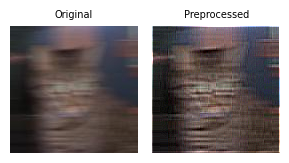

Processing cat.10.jpg (Noise: motion_blur)


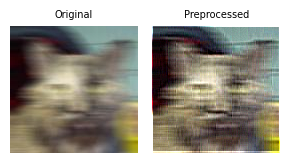

Processing cat.100.jpg (Noise: motion_blur)


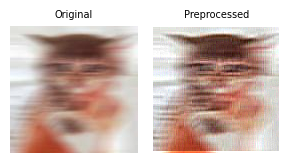

Processing cat.1000.jpg (Noise: motion_blur)


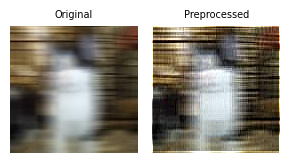

Processing cat.1001.jpg (Noise: motion_blur)


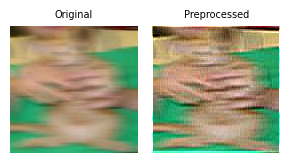

Processing cat.1.jpg (Noise: salt_and_pepper_noise)


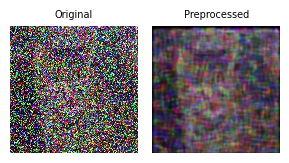

Processing cat.10.jpg (Noise: salt_and_pepper_noise)


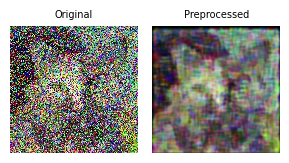

Processing cat.100.jpg (Noise: salt_and_pepper_noise)


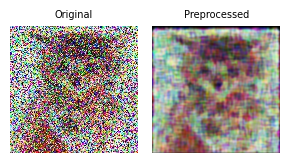

Processing cat.1000.jpg (Noise: salt_and_pepper_noise)


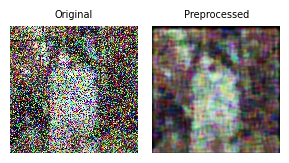

Processing cat.1001.jpg (Noise: salt_and_pepper_noise)


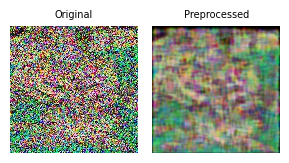

Processing dog.1.jpg (Noise: motion_blur)


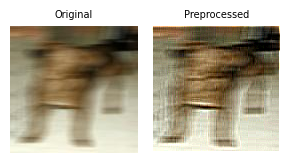

Processing dog.10.jpg (Noise: motion_blur)


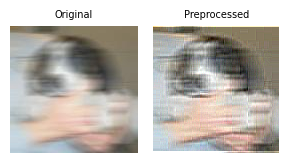

Processing dog.100.jpg (Noise: motion_blur)


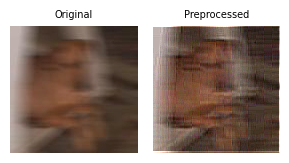

Processing dog.1000.jpg (Noise: motion_blur)


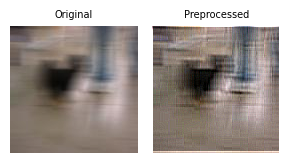

Processing dog.1001.jpg (Noise: motion_blur)


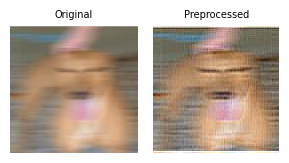

Processing dog.1.jpg (Noise: salt_and_pepper_noise)


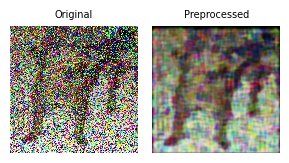

Processing dog.10.jpg (Noise: salt_and_pepper_noise)


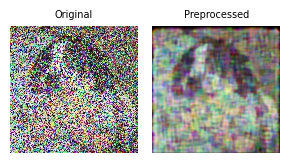

Processing dog.100.jpg (Noise: salt_and_pepper_noise)


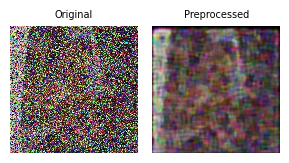

Processing dog.1000.jpg (Noise: salt_and_pepper_noise)


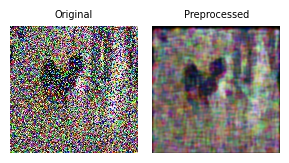

Processing dog.1001.jpg (Noise: salt_and_pepper_noise)


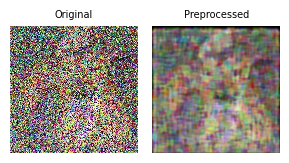

Processing Validation Data...
Processing cat.4001.jpg (Noise: motion_blur)


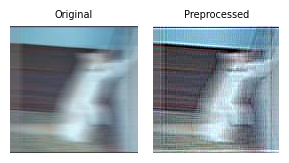

Processing cat.4002.jpg (Noise: motion_blur)


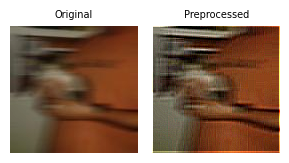

Processing cat.4003.jpg (Noise: motion_blur)


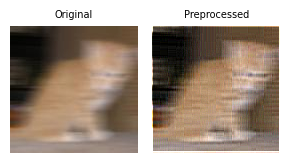

Processing cat.4004.jpg (Noise: motion_blur)


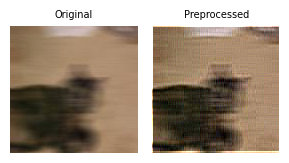

Processing cat.4005.jpg (Noise: motion_blur)


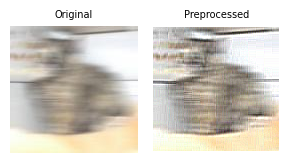

Processing cat.4001.jpg (Noise: salt_and_pepper_noise)


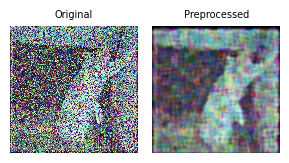

Processing cat.4002.jpg (Noise: salt_and_pepper_noise)


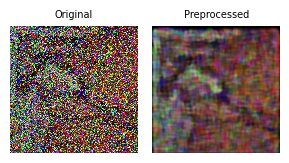

Processing cat.4003.jpg (Noise: salt_and_pepper_noise)


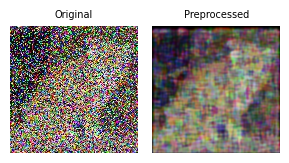

Processing cat.4004.jpg (Noise: salt_and_pepper_noise)


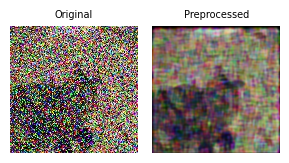

Processing cat.4005.jpg (Noise: salt_and_pepper_noise)


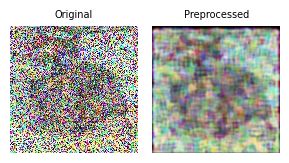

Processing dog.4001.jpg (Noise: motion_blur)


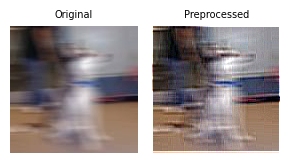

Processing dog.4002.jpg (Noise: motion_blur)


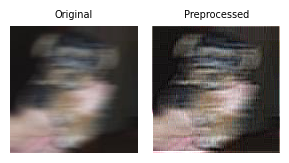

Processing dog.4003.jpg (Noise: motion_blur)


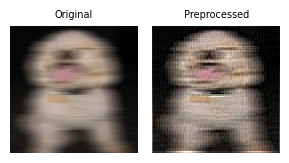

Processing dog.4004.jpg (Noise: motion_blur)


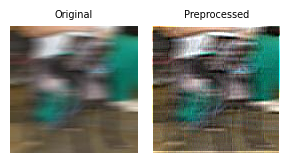

Processing dog.4005.jpg (Noise: motion_blur)


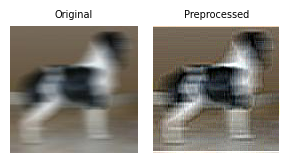

Processing dog.4001.jpg (Noise: salt_and_pepper_noise)


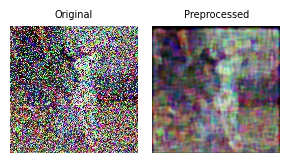

Processing dog.4002.jpg (Noise: salt_and_pepper_noise)


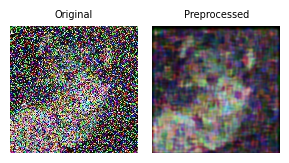

Processing dog.4003.jpg (Noise: salt_and_pepper_noise)


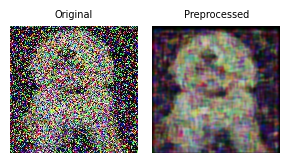

Processing dog.4004.jpg (Noise: salt_and_pepper_noise)


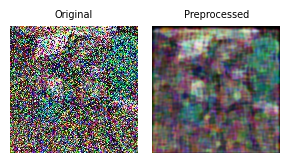

Processing dog.4005.jpg (Noise: salt_and_pepper_noise)


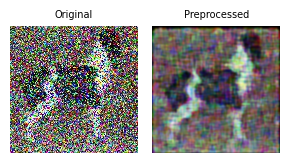

In [ ]:
# Load and preprocess training data
cat_train_images, cat_train_labels = load_and_preprocess_images(os.path.join(train_dir, 'cats'), label=0, display_samples=True, num_display_samples=5)
dog_train_images, dog_train_labels = load_and_preprocess_images(os.path.join(train_dir, 'dogs'), label=1, display_samples=True, num_display_samples=5)

# Load and preprocess test data
cat_test_images, cat_test_labels = load_and_preprocess_images(os.path.join(test_dir, 'cats'), label=0, display_samples=True, num_display_samples=5)
dog_test_images, dog_test_labels = load_and_preprocess_images(os.path.join(test_dir, 'dogs'), label=1, display_samples=True, num_display_samples=5)

# Combine training and test data
X_train = np.concatenate((cat_train_images, dog_train_images)) / 255.0  # Normalize images
y_train = np.concatenate((cat_train_labels, dog_train_labels))
X_val = np.concatenate((cat_test_images, dog_test_images)) / 255.0
y_val = np.concatenate((cat_test_labels, dog_test_labels))

# Shuffle training data
np.random.seed(42)
train_indices = np.arange(len(X_train))
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

# Shuffle validation data
val_indices = np.arange(len(X_val))
np.random.shuffle(val_indices)
X_val = X_val[val_indices]
y_val = y_val[val_indices]

In [ ]:
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (16000, 128, 128, 3)
Validation data shape: (4000, 128, 128, 3)


### Building the Model

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu',kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Training the Model

In [ ]:
# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.7533 - loss: 65.7007 - val_accuracy: 0.5005 - val_loss: 4.2601 - learning_rate: 1.0000e-04
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8365 - loss: 1.8607 - val_accuracy: 0.8490 - val_loss: 1.0579 - learning_rate: 1.0000e-04
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8430 - loss: 0.9955 - val_accuracy: 0.8325 - val_loss: 0.9073 - learning_rate: 1.0000e-04
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8525 - loss: 0.8417 - val_accuracy: 0.8500 - val_loss: 0.7553 - learning_rate: 1.0000e-04
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8669 - loss: 0.7269 - val_accuracy: 0.8405 - val_loss: 0.8590 - learning_rate: 1.0000e-04
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8695 - loss: 0.7443 - val_accuracy: 0.8727 - val_loss: 0.6702 - learning_rate: 1.0000e-04
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - a

### Evaluating the Model

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9061 - loss: 0.2832
Accuracy: 0.9128
Loss: 0.2797


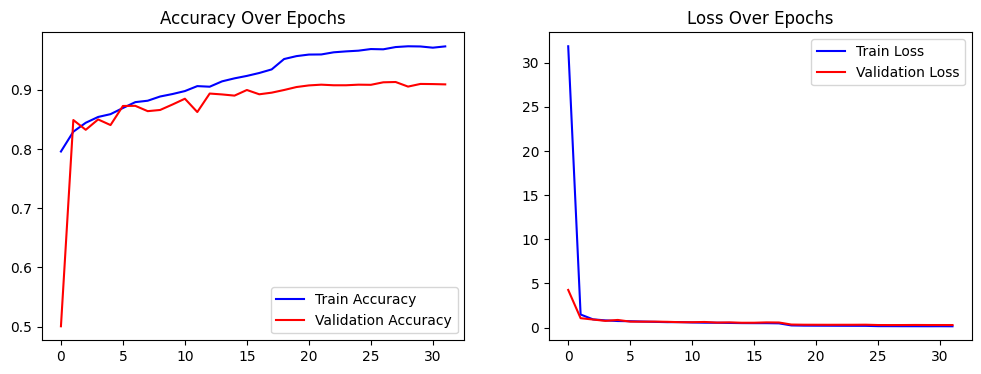

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


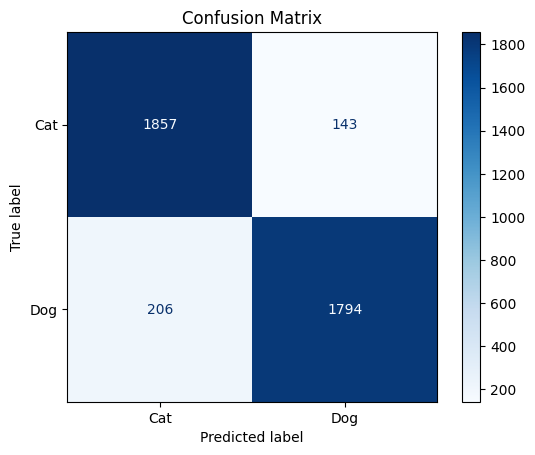

In [ ]:
# Evaluate model performance
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Accuracy: {accuracy:.4f}")
print(f"Loss: {loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title("Accuracy Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title("Loss Over Epochs")
plt.legend()

plt.show()

# Confusion Matrix
y_pred = model.predict(X_val)
y_pred_binary = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


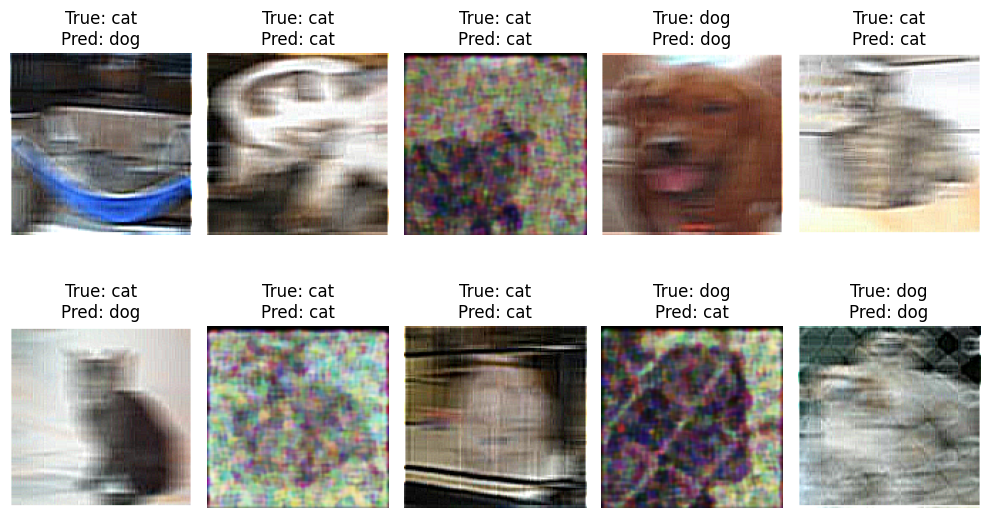

In [ ]:
# Random Predictions
# Define the number of samples and rows
num_samples = 10  # Total number of samples to display
num_cols = 5  # Number of columns per row
num_rows = (num_samples + num_cols - 1) // num_cols  # Calculate required rows
# Select random indices from the test set
random_indices = np.random.choice(len(X_val), num_samples, replace=False)
# Plot the random predictions
plt.figure(figsize=(10, num_rows * 3))
for i, idx in enumerate(random_indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_val[idx], cmap='gray')  # Display the image
    # Get true and predicted labels
    true_label = 'dog' if y_val[idx] == 1 else 'cat'  # True label
    pred_label = 'dog' if y_pred[idx][0] == 1 else 'cat'  # Predicted label
    # Title for true and predicted labels
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()